In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from clust_huge_amp import *
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="sklearn.utils.extmath")


## Aladynoulli retrospective

Here we show the ability of the model to estatime when having access to all data for signature and genomic discovery, heterogeneity characterization, and cohort similarity.

In [2]:
%load_ext autoreload
%autoreload 2



%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

def load_model_essentials(base_path='/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading components...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_99442/2084552305.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/v

Loaded all components successfully!


In [8]:
from clust_huge_amp import *
# Subset the data
Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, start_index=0, end_index=10000)

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Initialize model with subsetted data

del Y

In [9]:
# Load references (signatures only, no healthy)
refs = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/reference_trajectories.pt')
signature_refs = refs['signature_refs']
# When initializing the model:


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96773/2694258374.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refs = torch.load('/Users/sarahurbut/Library/

In [10]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the RDS file
readRDS = robjects.r['readRDS']
pce_data = readRDS('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/pce_df_prevent.rds')
pce_df = pandas2ri.rpy2py(pce_data)  # Convert to pandas DataFrame


In [11]:

readRDS = robjects.r['readRDS']
pce_data = readRDS('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/pce_df_prevent.rds')
pce_df = pandas2ri.rpy2py(pce_data)  # Convert to pandas DataFrame
sex=pce_df['Sex'].values

# Convert to numeric: Female=0, Male=1

pce_df['sex_numeric'] = pce_df['Sex'].map({'Female': 0, 'Male': 1}).astype(int)

sex=pce_df['sex_numeric'].values
G_with_sex = np.column_stack([G_100k, sex])  # sex should be numeric (e.g., 0/1)
# N

In [12]:


model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0], 
    D=Y_100k.shape[1], 
    T=Y_100k.shape[2], 
    K=20,
    P=G_with_sex.shape[1],
    init_sd_scaler=1e-1,
    G=G_with_sex, 
    Y=Y_100k,
    genetic_scale=1,
    W=0.0001,
    R=0,
    prevalence_t=essentials['prevalence_t'],
    signature_references=signature_refs,  # Only pass signature refs
    healthy_reference=True,  # Explicitly set to None
    disease_names=essentials['disease_names']
)

torch.manual_seed(0)
np.random.seed(0)
# Initialize with psi and clusters


import cProfile
import pstats
from pstats import SortKey

# Now in your batch run, load and verify:
initial_psi = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_psi_400k.pt')
initial_clusters = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_clusters_400k.pt')

model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters
# Verify clusters match
clusters_match = np.array_equal(initial_clusters, model.clusters)
print(f"\nClusters match exactly: {clusters_match}")


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)



Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 14
Base value (first 5): tensor([-13.8155, -13.8155, -13.1095, -12.4036, -12.4036])
Base value centered (first 5): tensor([-0.3723, -0.3723,  0.3336,  1.0396,  1.0396])
Base value centered mean: 6.57081614008348e-07
Gamma init for k=0 (first 5): tensor([ 0.0008,  0.0071,  0.0117,  0.0152, -0.0106])

Calculating gamma for k=1:
Number of diseases in cluster: 7
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96773/612023066.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/L


Calculating gamma for k=2:
Number of diseases in cluster: 15.0
Base value (first 5): tensor([-13.8155, -13.8155, -13.1566, -11.8388, -12.4977])
Base value centered (first 5): tensor([-0.3849, -0.3849,  0.2740,  1.5918,  0.9329])
Base value centered mean: 9.290695288655115e-07
Gamma init for k=2 (first 5): tensor([-0.0001,  0.0092,  0.0113,  0.0160, -0.0109])

Calculating gamma for k=3:
Number of diseases in cluster: 82.0
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.6950, -13.5744])
Base value centered (first 5): tensor([-0.1026, -0.1026, -0.1026,  0.0179,  0.1384])
Base value centered mean: 4.7445297468584613e-07
Gamma init for k=3 (first 5): tensor([ 0.0011,  0.0003,  0.0017,  0.0019, -0.0006])

Calculating gamma for k=4:
Number of diseases in cluster: 5.0
Base value (first 5): tensor([-13.8155,  -9.8620, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.1133,  3.8402, -0.1133, -0.1133, -0.1133])
Base value centered mean: -2.841758714566822e-

# you can see that we use the full unmodified E matrix here

In [13]:
## now we will run the model with the full data and sex specific
import cProfile
import pstats
from pstats import SortKey
# 5. Train on FULL data
profiler = cProfile.Profile()
profiler.enable()

history_new = model.fit(E_100k, num_epochs=200, learning_rate=1e-1, lambda_reg=1e-2)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats(SortKey.CUMULATIVE)
stats.print_stats(20)

/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_times_tensor = torch.tensor(event_times, dtype=torch.long)



Epoch 0
Loss: 65.7505

Monitoring signature responses:

Disease 161 (signature 7, LR=32.38):
  Theta for diagnosed: 0.150 ± 0.038
  Theta for others: 0.147
  Proportion difference: 0.003

Disease 76 (signature 7, LR=30.81):
  Theta for diagnosed: 0.153 ± 0.039
  Theta for others: 0.147
  Proportion difference: 0.005

Disease 260 (signature 8, LR=30.45):
  Theta for diagnosed: 0.097 ± 0.081
  Theta for others: 0.087
  Proportion difference: 0.010

Disease 347 (signature 3, LR=29.51):
  Theta for diagnosed: 0.149 ± 0.070
  Theta for others: 0.150
  Proportion difference: -0.001

Disease 50 (signature 15, LR=28.94):
  Theta for diagnosed: 0.016 ± 0.006
  Theta for others: 0.014
  Proportion difference: 0.002

Epoch 1
Loss: 707.3983

Monitoring signature responses:

Disease 161 (signature 7, LR=32.57):
  Theta for diagnosed: 0.150 ± 0.036
  Theta for others: 0.147
  Proportion difference: 0.003

Disease 76 (signature 7, LR=30.82):
  Theta for diagnosed: 0.153 ± 0.037
  Theta for others: 0

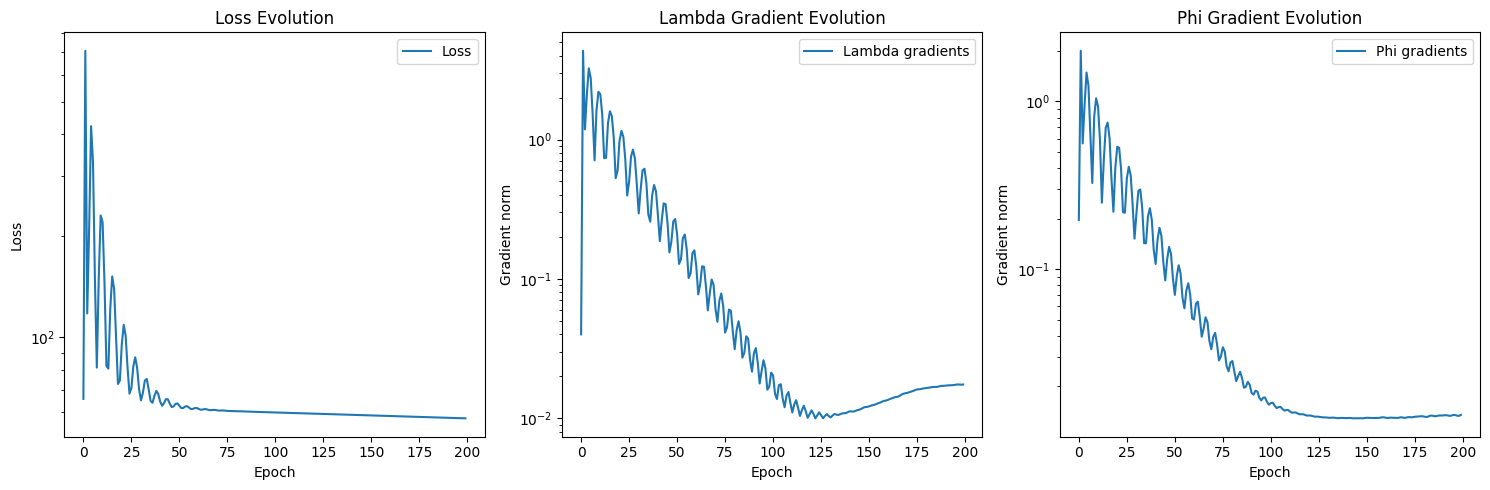

In [19]:
from utils import *
plot_training_evolution(history_new)

In [21]:

# Save model
W=0.0001
torch.save({
    'model_state_dict': model.state_dict(),
    'phi': model.phi,
    'Y': model.Y,
    'prevalence_t': model.prevalence_t,
    'logit_prevalence_t': model.logit_prev_t,
    'G': model.G,
}, f'/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_model_W{W}_fulldata_sexspecific_921.pt')

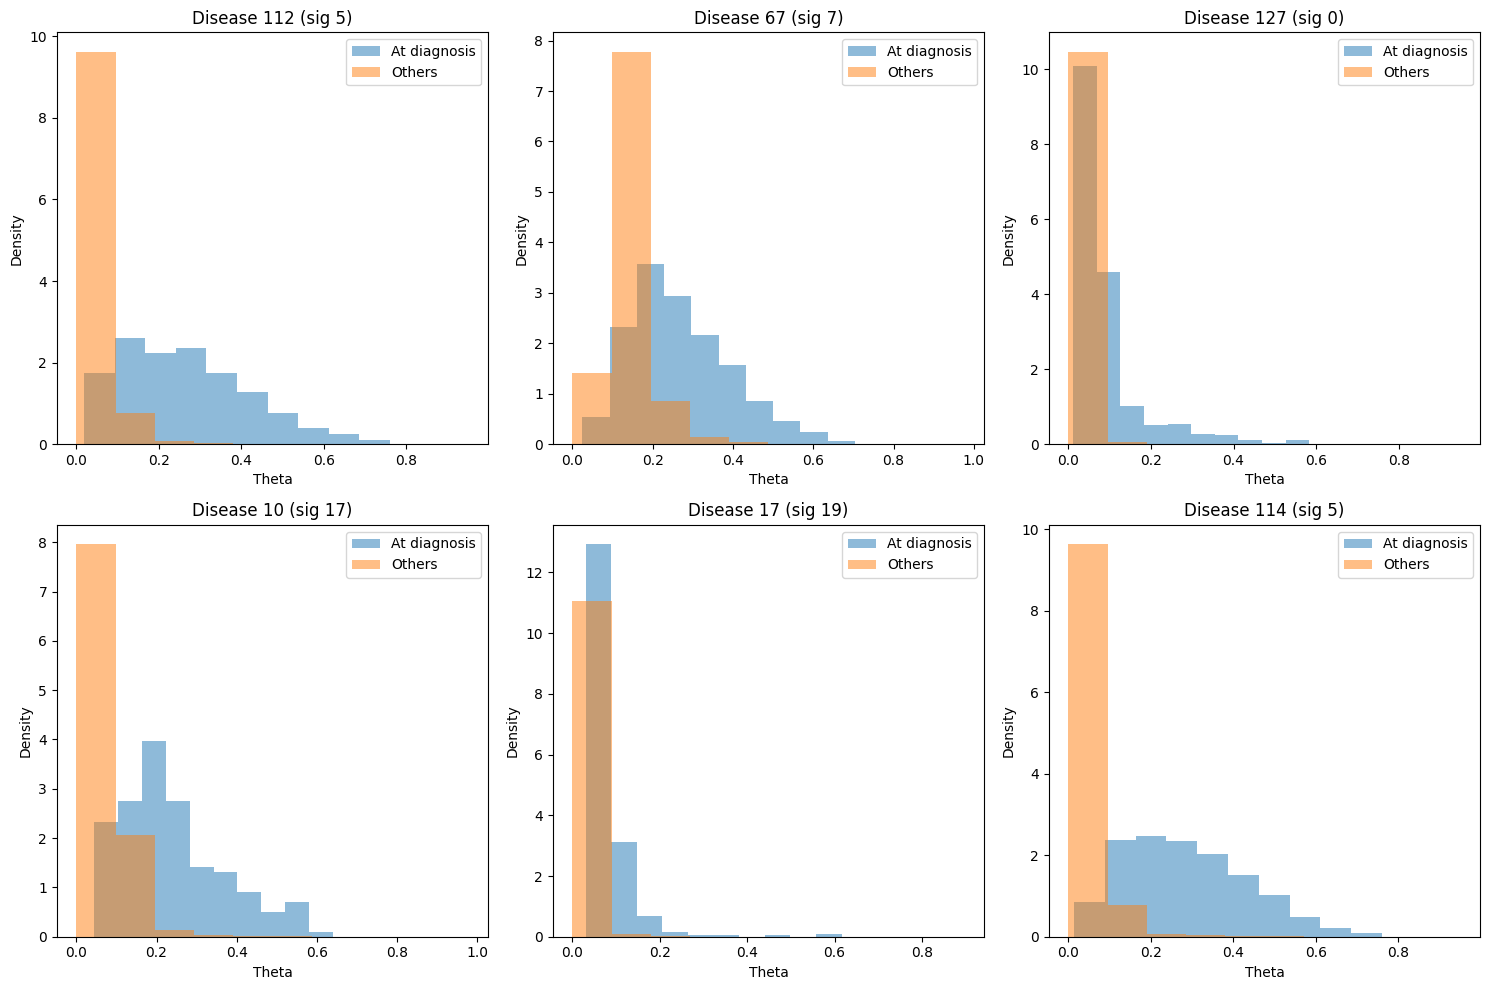

In [20]:

plot_theta_differences(model, diseases=[112,67,127,10,17,114], signatures=[5,7,0,17,19,5])

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load both models
W = 0.0001  # or whatever W value you used
model_old = torch.load(f'/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/enrollment_model_W{W}_fulldata_sexspecific.pt')
model_new = torch.load(f'/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_model_W{W}_fulldata_sexspecific_921.pt')

# Extract phi and lambda parameters
phi_old = model_old['model_state_dict']['phi'].detach().numpy()
phi_new = model_new['model_state_dict']['phi'].detach().numpy()

lambda_old = model_old['model_state_dict']['lambda_'].detach().numpy()
lambda_new = model_new['model_state_dict']['lambda_'].detach().numpy()

# Compare phi parameters
print("PHI COMPARISON:")
print(f"Phi shape: {phi_old.shape}")
print(f"Phi difference (L2 norm): {np.linalg.norm(phi_new - phi_old):.6f}")
print(f"Phi relative difference: {np.linalg.norm(phi_new - phi_old) / np.linalg.norm(phi_old):.6f}")
print(f"Phi max absolute difference: {np.max(np.abs(phi_new - phi_old)):.6f}")

# Compare lambda parameters
print("\nLAMBDA COMPARISON:")
print(f"Lambda shape: {lambda_old.shape}")
print(f"Lambda difference (L2 norm): {np.linalg.norm(lambda_new - lambda_old):.6f}")
print(f"Lambda relative difference: {np.linalg.norm(lambda_new - lambda_old) / np.linalg.norm(lambda_old):.6f}")
print(f"Lambda max absolute difference: {np.max(np.abs(lambda_new - lambda_old)):.6f}")


PHI COMPARISON:
Phi shape: (21, 348, 52)
Phi difference (L2 norm): 0.000000
Phi relative difference: 0.000000
Phi max absolute difference: 0.000000

LAMBDA COMPARISON:
Lambda shape: (10000, 21, 52)
Lambda difference (L2 norm): 0.000000
Lambda relative difference: 0.000000
Lambda max absolute difference: 0.000000


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_96773/556017945.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_old = torch.load(f'/Users/sarahurbut/Lib

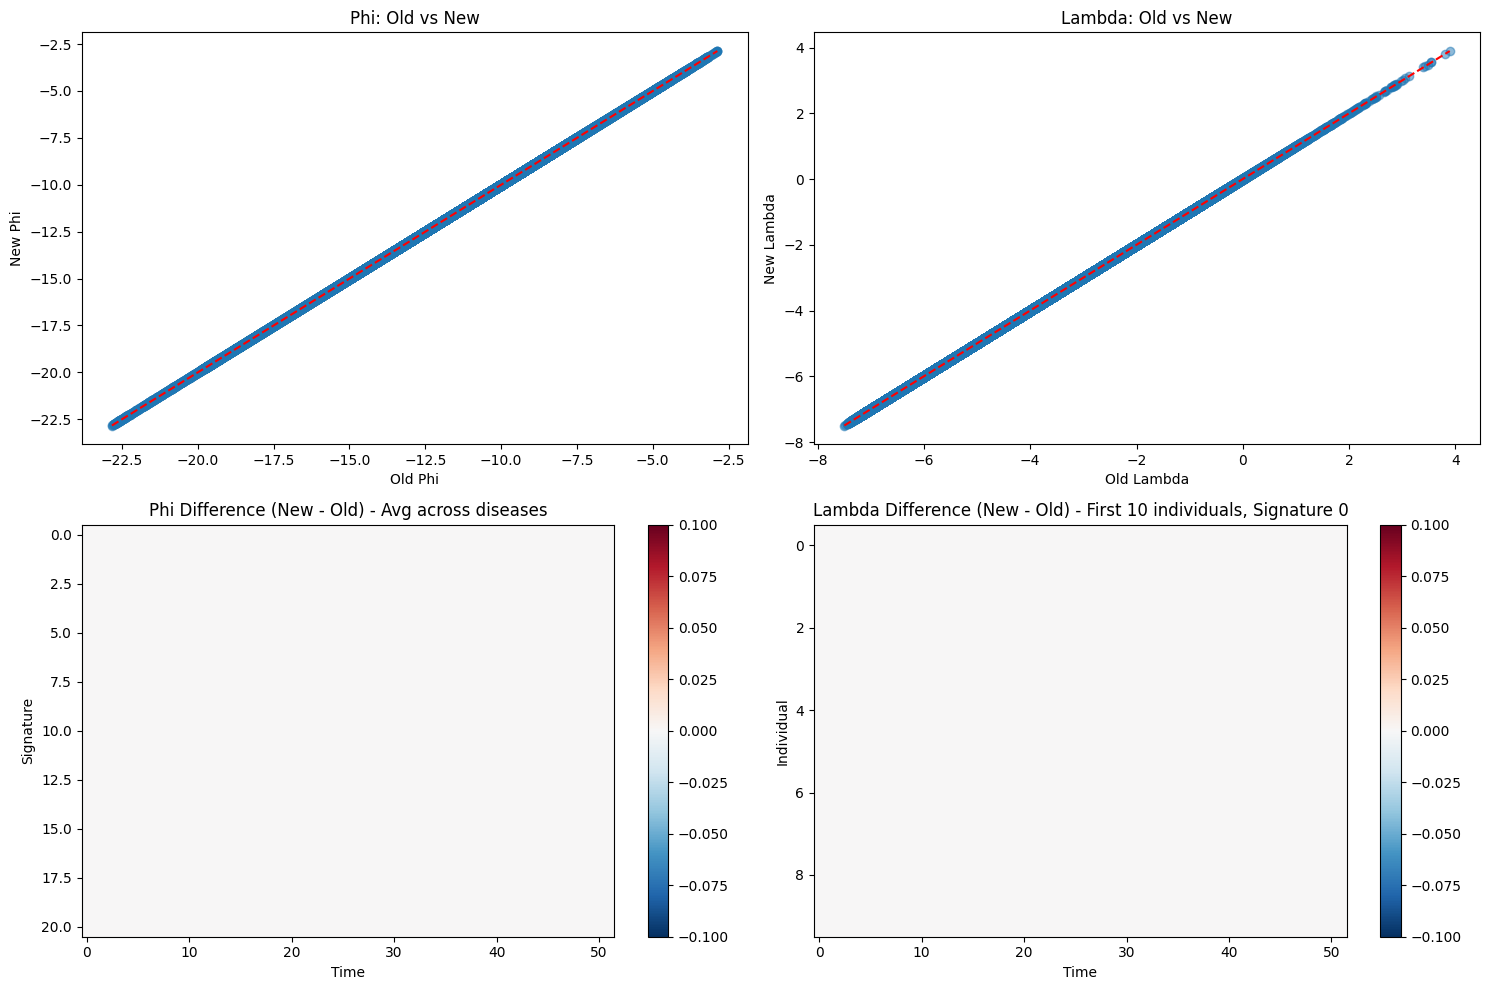


SUMMARY:
Models are IDENTICAL - no changes detected!
Phi correlation: 1.0000
Lambda correlation: 1.0000


In [31]:

# Plot comparisons
# Fixed plotting code
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Phi comparison - scatter plot
axes[0, 0].scatter(phi_old.flatten(), phi_new.flatten(), alpha=0.5)
axes[0, 0].plot([phi_old.min(), phi_old.max()], [phi_old.min(), phi_old.max()], 'r--')
axes[0, 0].set_xlabel('Old Phi')
axes[0, 0].set_ylabel('New Phi')
axes[0, 0].set_title('Phi: Old vs New')

# Lambda comparison - scatter plot
axes[0, 1].scatter(lambda_old.flatten(), lambda_new.flatten(), alpha=0.5)
axes[0, 1].plot([lambda_old.min(), lambda_old.max()], [lambda_old.min(), lambda_old.max()], 'r--')
axes[0, 1].set_xlabel('Old Lambda')
axes[0, 1].set_ylabel('New Lambda')
axes[0, 1].set_title('Lambda: Old vs New')

# Phi difference heatmap - average across diseases
phi_diff = phi_new - phi_old
phi_diff_avg = np.mean(phi_diff, axis=1)  # Average across diseases
im1 = axes[1, 0].imshow(phi_diff_avg, aspect='auto', cmap='RdBu_r')
axes[1, 0].set_title('Phi Difference (New - Old) - Avg across diseases')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Signature')
plt.colorbar(im1, ax=axes[1, 0])

# Lambda difference heatmap - first few individuals, first signature
lambda_diff = lambda_new - lambda_old
im2 = axes[1, 1].imshow(lambda_diff[:10, 0, :], aspect='auto', cmap='RdBu_r')
axes[1, 1].set_title('Lambda Difference (New - Old) - First 10 individuals, Signature 0')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Individual')
plt.colorbar(im2, ax=axes[1, 1])

plt.tight_layout()
plt.show()

print(f"\nSUMMARY:")
print(f"Models are IDENTICAL - no changes detected!")
print(f"Phi correlation: {np.corrcoef(phi_old.flatten(), phi_new.flatten())[0,1]:.4f}")
print(f"Lambda correlation: {np.corrcoef(lambda_old.flatten(), lambda_new.flatten())[0,1]:.4f}")

In [29]:
model_new['model_state_dict'].keys()

odict_keys(['kappa', 'gamma', 'lambda_', 'phi', 'psi'])